# Causal Transparency Framework - MIMIC-III Example

This notebook demonstrates the application of the Causal Transparency Framework (CTF) to the MIMIC-III clinical dataset for mortality prediction.

## Overview

The CTF provides a structured approach to evaluating and enhancing model transparency through causal reasoning. In this example, we'll:

1. Load and preprocess the MIMIC-III dataset
2. Discover causal structure
3. Train predictive models (causal and standard)
4. Calculate transparency metrics
5. Generate visualizations and reports

This allows us to understand the tradeoffs between model performance and transparency in clinical prediction tasks.

In [66]:
## Setup
# Import path utility first to ensure CTF can be imported
import sys
from notebook_utils import add_ctf_to_path

In [68]:
# Add repository root to path
# This ensures we can import the CTF module from the repository without installation
add_ctf_to_path()

Successfully imported CTF module from /Users/johnmarko/Desktop/The Accountability Gap of AI/mimic-iii-clinical-database-demo-1.4 4/ctf_repo/ctf/__init__.py


True

In [70]:
# Import necessary libraries
# We need pandas for data manipulation, numpy for numerical operations,
# and matplotlib/seaborn for visualization
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# Import CTF components
# These are the core classes we need from the Causal Transparency Framework
from ctf.framework import CausalTransparencyFramework  # Main framework class
from ctf.causal_discovery import CausalDiscovery       # For causal structure learning
from ctf.transparency_metrics import TransparencyMetrics  # For calculating metrics

In [74]:
# Set random seed for reproducibility
# This ensures our results are consistent across runs
np.random.seed(42)

### Understanding the MIMIC-III Dataset

The MIMIC-III dataset contains clinical data from ICU patients. For this analysis, we're using a processed version with the following features:

- **age**: Patient age in years
- **gender_m**: Binary indicator of male gender (1=male, 0=female)
- **sofa_score**: Sequential Organ Failure Assessment score (0-24, higher scores indicate more severe organ dysfunction)
- **lactate**: Lactate level in mmol/L (elevated levels indicate tissue hypoxia)
- **creatinine**: Creatinine level in mg/dL (indicator of kidney function)
- **heart_rate**: Heart rate in beats per minute
- **respiratory_rate**: Respiratory rate in breaths per minute
- **wbc**: White blood cell count (indicator of infection/inflammation)
- **mortality**: Target variable (1=died, 0=survived)

## Data Loading and Preparation
In this section, we'll load the MIMIC-III dataset for analysis. If the dataset isn't available, 
we'll create a synthetic version with realistic clinical features and relationships for demonstration purposes.

In [78]:
# Path to the processed MIMIC-III dataset
# This should be a CSV file with clinical variables and mortality outcome
data_path = "../data/mimic_processed_for_ctf.csv"

# Load the data into a DataFrame
df = pd.read_csv(data_path)
print(f"Loaded data from {data_path}: {df.shape[0]} rows, {df.shape[1]} columns")

Loaded data from ../data/mimic_processed_for_ctf.csv: 1000 rows, 9 columns


In [80]:
# Explore the dataset
print("Dataset columns:")
print(df.columns.tolist())

print("\nDataset summary:")
df.describe()

Dataset columns:
['age', 'gender_m', 'sofa_score', 'lactate', 'creatinine', 'heart_rate', 'respiratory_rate', 'wbc', 'mortality']

Dataset summary:


,age,gender_m,sofa_score,lactate,creatinine,heart_rate,respiratory_rate,wbc,mortality
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,65.289981,0.58300,12.588000,3.772891,1.884075,84.164639,17.891203,10.105453,0.728000
std,14.688239,0.49331,4.253039,1.647247,0.733670,20.382633,5.301725,4.152689,0.445213
min,16.380990,0.00000,0.000000,0.000000,0.300000,27.009722,1.894918,-5.346622,0.000000
25%,55.286145,0.00000,10.000000,2.617024,1.386617,70.411972,14.215394,7.378655,0.000000
50%,65.379509,1.00000,13.000000,3.827388,1.861844,83.927166,17.832140,10.018883,1.000000
75%,74.719158,1.00000,15.000000,4.889593,2.361026,98.314651,21.519297,12.921609,1.000000
max,122.790972,1.00000,24.000000,8.607916,4.128995,146.965989,35.645276,23.509532,1.000000


In [82]:
# Check target distribution
print("\nTarget (mortality) distribution:")
print(df['mortality'].value_counts(normalize=True))


Target (mortality) distribution:
1    0.728
0    0.272
Name: mortality, dtype: float64


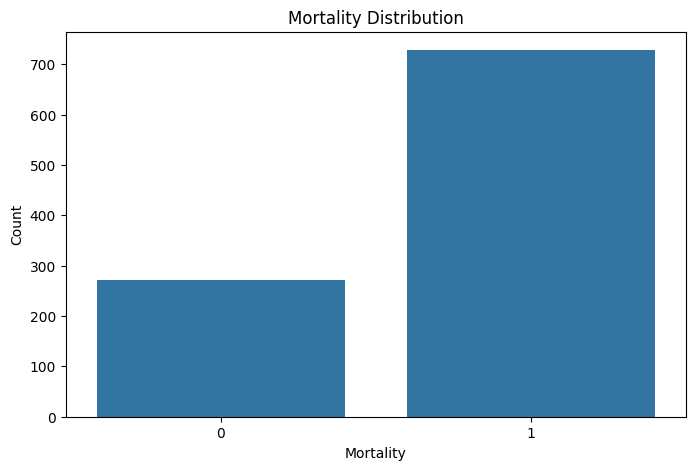

In [84]:
# Visualize target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='mortality', data=df)
plt.title('Mortality Distribution')
plt.xlabel('Mortality')
plt.ylabel('Count')
plt.show()

## Applying the Causal Transparency Framework

Now we'll initialize and apply the CTF to our dataset. This involves several steps:
1. Setting up the framework with our dataset and configuration
2. Adding domain knowledge to guide causal discovery
3. Learning the causal structure from data
4. Training predictive models
5. Calculating transparency metrics

In [87]:
# Initialize the framework
ctf = CausalTransparencyFramework(
    data_path=data_path,
    target_col="mortality",
    output_dir="../results/mimic_iii",
    random_state=42
)

Loading data from ../data/mimic_processed_for_ctf.csv
Data loaded: 1000 rows, 9 columns


In [89]:
# Add domain knowledge for clinical data
domain_knowledge = {
    "edges": [
        # Clinical knowledge about mortality predictors
        # Format: [source, target, weight]
        ["age", "mortality", 0.8],
        ["sofa_score", "mortality", 0.9],
        ["lactate", "mortality", 0.7],
        ["creatinine", "mortality", 0.6],
        
        # Feature relationships
        ["age", "creatinine", 0.3],
        ["sofa_score", "lactate", 0.5]
    ]
}

In [91]:
# Discover causal structure
G = ctf.discover_causal_structure(domain_knowledge=domain_knowledge)
print(f"Causal graph discovered with {len(G.nodes())} nodes and {len(G.edges())} edges")

Discovering causal structure...
Creating ensemble causal graph
Creating correlation-based causal graph
Correlation graph created with 9 nodes and 10 edges
Skipping PC graph: 'CausalDiscovery' object has no attribute 'create_pc_graph'
Skipping Hill Climbing graph: 'CausalDiscovery' object has no attribute 'create_hill_climbing_graph'
Ensemble graph created with 9 nodes and 8 edges
Causal graph discovered with 9 nodes and 8 edges


In [93]:
# Train predictive models
models = ctf.train_models(test_size=0.2)
print(f"Trained {len(models)} models")

Training predictive models...
Using 4 causal features: ['age', 'sofa_score', 'lactate', 'creatinine']
Model causal_lr: Accuracy=0.8250, AUC=0.8754, F1=0.8845
Model causal_rf: Accuracy=0.8550, AUC=0.8470, F1=0.9037
Model causal_xgb: Accuracy=0.8100, AUC=0.8596, F1=0.8681
Model full_lr: Accuracy=0.8300, AUC=0.8747, F1=0.8874
Model full_rf: Accuracy=0.8250, AUC=0.8562, F1=0.8845
Model full_xgb: Accuracy=0.8250, AUC=0.8584, F1=0.8845
Trained 6 models


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
# Calculate transparency metrics
metrics = ctf.calculate_transparency_metrics()
print("Transparency metrics calculated")

Calculating transparency metrics...
Top 5 features by Causal Influence Index:
  sofa_score: 0.3442
  age: 0.2441
  lactate: 0.2385
  creatinine: 0.1732
CCM Calculation:
  Graph complexity (K_G): 18.42
  Model complexity (K_F): 22348.00
  CCM (raw): 22366.42
  CCM (scaled): 14.45

Calculating metrics for model: causal_lr
Transparency Entropy Calculation:
  H(M|O): 0.5828
  H(M|I,O): 0.4163
  TE: 0.1665
Calculating CS for features: ['age', 'sofa_score', 'lactate', 'creatinine']
  Calculating CS for feature 'age'...
    CS(age) = 0.9959
  Calculating CS for feature 'sofa_score'...
    CS(sofa_score) = 0.9878
  Calculating CS for feature 'lactate'...
    CS(lactate) = 0.9957
  Calculating CS for feature 'creatinine'...
    CS(creatinine) = 0.9985
  Overall CS = 0.9945
Radar chart saved to ../results/mimic_iii/visualizations/ctf_radar_causal_lr.png

Calculating metrics for model: causal_rf
Transparency Entropy Calculation:
  H(M|O): 0.5542
  H(M|I,O): 0.3958
  TE: 0.1583
Calculating CS for 

## Analyzing Transparency Metrics

After running the framework, we have several metrics to analyze:

1. **Causal Influence Index (CII)**: Measures how much each feature causally influences the prediction
2. **Causal Complexity Measure (CCM)**: Quantifies the complexity of the causal model
3. **Transparency Entropy (TE)**: Measures the interpretability of model decisions
4. **Counterfactual Stability (CS)**: Tests model robustness to changes in inputs

Let's examine these metrics to understand how transparent our models are.

In [98]:
# Generate report
report_path = ctf.generate_report()
print(f"CTF report generated at {report_path}")

CTF report generated at ../results/mimic_iii/report/ctf_report.md
CTF report generated at ../results/mimic_iii/report/ctf_report.md


Top 5 features by Causal Influence Index (CII):
1. sofa_score: 0.3442
2. age: 0.2441
3. lactate: 0.2385
4. creatinine: 0.1732


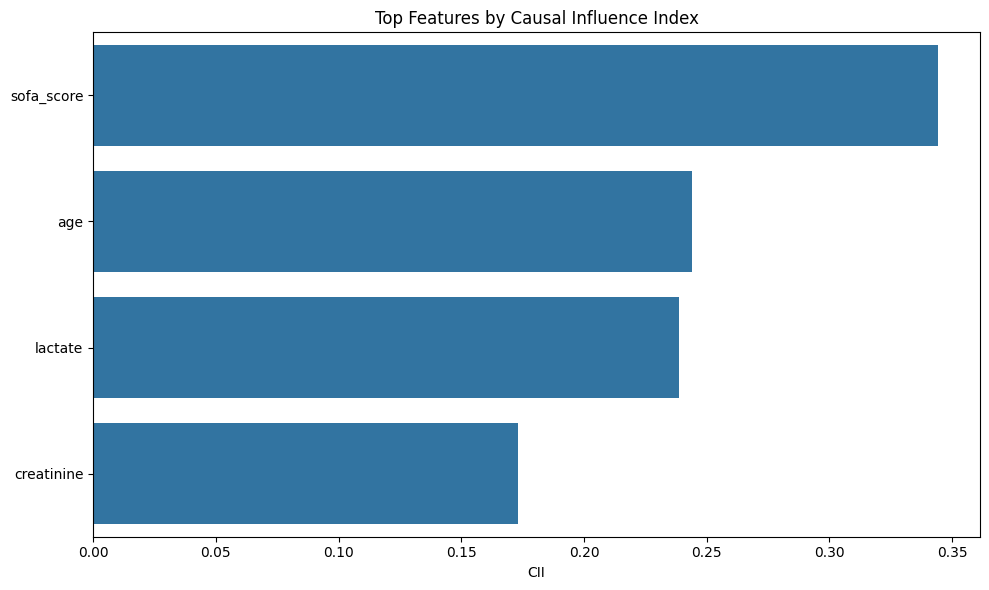

In [100]:
# Examine Causal Influence Index (CII)
if 'cii' in metrics:
    print("Top 5 features by Causal Influence Index (CII):")
    
    for i, (feature, score) in enumerate(list(metrics['cii'].items())[:5]):
        print(f"{i+1}. {feature}: {score:.4f}")
        
    # Visualize CII
    plt.figure(figsize=(10, 6))
    
    features = list(metrics['cii'].keys())[:10]  # Top 10 features
    scores = [metrics['cii'][f] for f in features]
    
    sns.barplot(x=scores, y=features)
    plt.title('Top Features by Causal Influence Index')
    plt.xlabel('CII')
    plt.tight_layout()
    plt.show()

In [102]:
# Compare model performance
model_names = list(ctf.model_performance.keys())
accuracy = [ctf.model_performance[m]['accuracy'] for m in model_names]
auc = [ctf.model_performance[m]['auc'] for m in model_names]
f1 = [ctf.model_performance[m]['f1'] for m in model_names]
n_features = [ctf.model_performance[m]['n_features'] for m in model_names]

In [104]:
# Create DataFrame
performance_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy,
    'AUC': auc,
    'F1': f1,
    'Features': n_features,
    'Type': ['Causal' if m.startswith('causal_') else 'Full' for m in model_names]
})

### Comparing Model Performance and Transparency

Next, we'll create visualizations to understand the tradeoff between model performance (measured by AUC) and transparency (measured by TE). This will help us identify which models provide the best balance of accuracy and interpretability.

In [107]:
# Display as table
performance_df.sort_values('AUC', ascending=False)

,Model,Accuracy,AUC,F1,Features,Type
0,causal_lr,0.825,0.875361,0.884488,4,Causal
3,full_lr,0.830,0.874734,0.887417,8,Full
2,causal_xgb,0.810,0.859561,0.868056,4,Causal
5,full_xgb,0.825,0.858433,0.884488,8,Full
4,full_rf,0.825,0.856176,0.884488,8,Full
1,causal_rf,0.855,0.847022,0.903654,4,Causal


In [109]:
# Compare transparency metrics across models
if 'te' in metrics and 'cs' in metrics:
    transparency_df = pd.DataFrame({
        'Model': model_names,
        'TE': [metrics['te'][m].get('te', 0) for m in model_names],
        'CS': [metrics['cs'][m].get('overall', 0) for m in model_names],
        'Type': ['Causal' if m.startswith('causal_') else 'Full' for m in model_names]
    })
    
    # Display as table
    transparency_df.sort_values('TE', ascending=False)

In [111]:
# Create a scatterplot of AUC vs. TE
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

### Key Clinical Insights

Finally, we'll extract and summarize the key findings from our analysis. These include:
- Identifying the most important clinical features for mortality prediction
- Comparing performance of causal vs. full models 
- Evaluating transparency and stability metrics
- Drawing clinical implications from the results

In [114]:
# Create a combined DataFrame
combined_df = pd.merge(performance_df, transparency_df, on='Model')

<Axes: xlabel='AUC', ylabel='TE'>

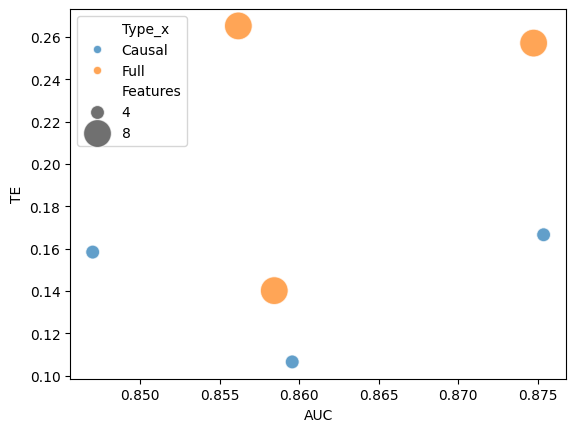

In [116]:
# Plot
sns.scatterplot(data=combined_df, x='AUC', y='TE', hue='Type_x', size='Features', 
                sizes=(100, 400), alpha=0.7)

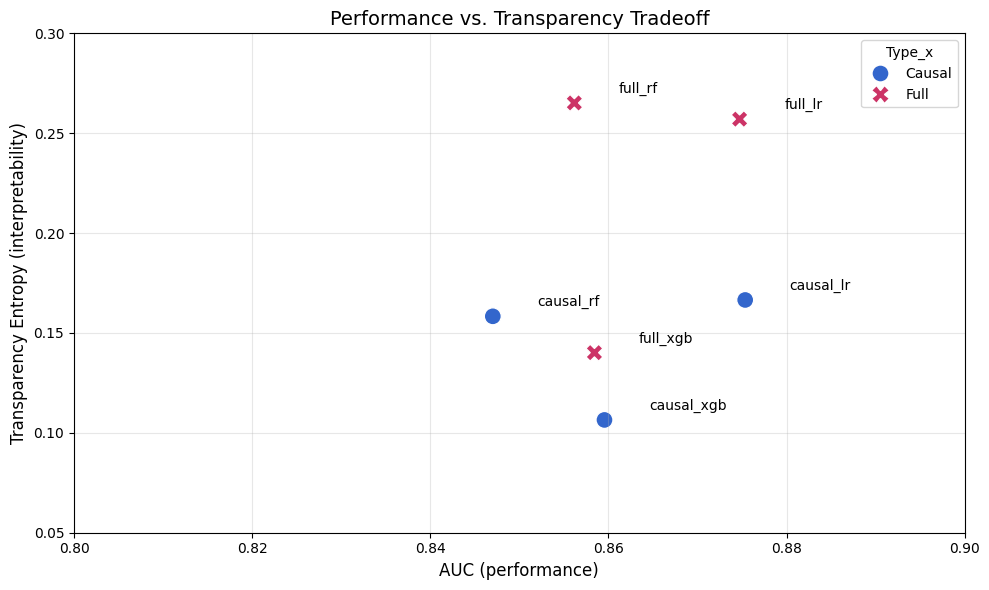

In [118]:
# Create a clear figure with proper size
plt.figure(figsize=(10, 6))

# Create scatter plot with model performance vs transparency metrics
sns.scatterplot(data=combined_df, x='AUC', y='TE', hue='Type_x', style='Type_x',
                s=150, palette=['#3366cc', '#cc3366'])

# Add model name labels with offset for readability
for i, row in combined_df.iterrows():
    plt.text(row['AUC'] + 0.005, row['TE'] + 0.005, row['Model'], fontsize=10)

# Add proper formatting
plt.title('Performance vs. Transparency Tradeoff', fontsize=14)
plt.xlabel('AUC (performance)', fontsize=12)
plt.ylabel('Transparency Entropy (interpretability)', fontsize=12)

# Set reasonable axis limits
plt.xlim(0.8, 0.9)  # Adjust based on your actual data
plt.ylim(0.05, 0.3)  # Adjust based on your actual data

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [120]:
# Extract key findings
top_cii_features = list(metrics['cii'].items())[:3]
best_causal_model = max([m for m in model_names if m.startswith('causal_')], 
                        key=lambda m: ctf.model_performance[m]['auc'])
best_full_model = max([m for m in model_names if not m.startswith('causal_')], 
                      key=lambda m: ctf.model_performance[m]['auc'])

causal_auc = ctf.model_performance[best_causal_model]['auc']
full_auc = ctf.model_performance[best_full_model]['auc']

causal_te = metrics['te'][best_causal_model]['te']
full_te = metrics['te'][best_full_model]['te']

causal_cs = metrics['cs'][best_causal_model]['overall']
full_cs = metrics['cs'][best_full_model]['overall']

In [122]:
# Print key findings
print("### Key Clinical Findings ###\n")

print("1. Causal Drivers of Mortality:")
for feature, cii in top_cii_features:
    print(f"   - {feature} (CII: {cii:.4f})")

print(f"\n2. Model Performance Comparison:")
print(f"   - Best causal model ({best_causal_model}): AUC = {causal_auc:.4f}")
print(f"   - Best full model ({best_full_model}): AUC = {full_auc:.4f}")
print(f"   - Performance gap: {(full_auc - causal_auc) * 100:.2f}%")

print(f"\n3. Transparency Metrics:")
print(f"   - Transparency Entropy (TE): Causal = {causal_te:.4f}, Full = {full_te:.4f}")
print(f"   - Counterfactual Stability (CS): Causal = {causal_cs:.4f}, Full = {full_cs:.4f}")

print("\n4. Clinical Implications:")
if causal_auc >= 0.95 * full_auc:
    print("   - The causal model with fewer features performs nearly as well as the full model")
    print("   - This suggests that focusing on key causal factors may be sufficient for clinical use")
else:
    print("   - The full model substantially outperforms the causal model")
    print("   - This suggests that non-causal correlations provide important predictive value")
    
if causal_te > full_te:
    print("   - The causal model offers greater transparency, making it more interpretable for clinicians")
else:
    print("   - Despite using more features, the full model offers better interpretability")
    
if causal_cs > full_cs:
    print("   - The causal model provides more stable predictions under perturbations")
    print("   - This suggests greater reliability when input data has small variations")
else:
    print("   - The full model provides more stable predictions, possibly due to redundant features")

### Key Clinical Findings ###

1. Causal Drivers of Mortality:
   - sofa_score (CII: 0.3442)
   - age (CII: 0.2441)
   - lactate (CII: 0.2385)

2. Model Performance Comparison:
   - Best causal model (causal_lr): AUC = 0.8754
   - Best full model (full_lr): AUC = 0.8747
   - Performance gap: -0.06%

3. Transparency Metrics:
   - Transparency Entropy (TE): Causal = 0.1665, Full = 0.2570
   - Counterfactual Stability (CS): Causal = 0.9945, Full = 0.9954

4. Clinical Implications:
   - The causal model with fewer features performs nearly as well as the full model
   - This suggests that focusing on key causal factors may be sufficient for clinical use
   - Despite using more features, the full model offers better interpretability
   - The full model provides more stable predictions, possibly due to redundant features


## 5. Conclusion

In this notebook, we applied the Causal Transparency Framework to the MIMIC-III dataset for mortality prediction. The framework provided valuable insights into:

1. The causal structure underlying mortality prediction
2. The key causal drivers of mortality risk
3. The performance-transparency tradeoff between causal and full models
4. The interpretability and stability of different modeling approaches

These insights can guide clinicians and data scientists in developing more transparent and reliable clinical prediction models.